In [ ]:
# default_exp final

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
# nbdev function - ensures that changed libraries from the project are reloaded
%load_ext autoreload
%autoreload 2

# Final preparations

In [ ]:
# imports
from bfh_mt_hs2020_sec_data.core import * 
from pathlib import Path
from typing import List, Tuple, Union, Set

import pandas as pd
import numpy as np

import shutil          # provides high level file operations
import time            # used to measure execution time
import os
import sys

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from yahoo_historical import Fetcher
import yfinance as yf

In [ ]:
all_data_local_folder = "./data/"
stock_data_folder = "D:/data/stocks/sec/"


join_group = ["cik","ticker","adsh","period","filed","form","fp"]

## 00_Tools

In [ ]:
def load_sec_features():
    return pd.read_csv(all_data_local_folder + "07_all_features_complete_corrected.csv", header = 0)

In [ ]:
def read_additional_info() -> pd.DataFrame:
    df =  pd.read_csv(all_data_local_folder + "08_add_ticker_info.csv", sep=',', encoding='utf-8', header=0)
    df =  df[df.message.isna()]
    return df.reset_index(drop=True)

## 01_Sector and Industries
Important features are the industry and the sector a company works in and in order to use these during training, wie have to one-hot-encode them.
There are about 12 different sectors and about 142 different industries in the data.

In [ ]:
add_info = read_additional_info()
print("length of dataset:           ", add_info.shape[0])
print("number of unique sectors:    ", len(add_info.sector.unique()))
print("number of unique industries: ",len(add_info.industry.unique()))

length of dataset:            2065
number of unique sectors:     12
number of unique industries:  142


In [ ]:
add_info['sector'] = add_info.sector.str.replace(' ','')
add_info = pd.concat([add_info, pd.get_dummies(add_info.sector, prefix='sec_')], axis=1)

it doesn't make sense to hot encode all 140 industries, we will only use industries which appear more than 20 times in the data (at least in one percent of the data). Othe industries will be set to "other"

In [ ]:
add_info['industry'] = add_info.industry.str.replace(' ','')
add_info['industry'] = add_info.industry.str.replace('&','')
add_info['industry'] = add_info.industry.str.replace('—','')

In [ ]:
df_industries = add_info.industry.value_counts()
df_relevant_industries = df_industries[df_industries > 20].index.tolist() # create a list with industries that appear at least 20 times in the data
add_info.loc[~add_info.industry.isin(df_relevant_industries),'industry'] = "Other"

In [ ]:
add_info = pd.concat([add_info, pd.get_dummies(add_info.industry, prefix='ind_')], axis=1)
add_info.shape

(2065, 47)

## 02_Market Capitalization
We will use the Market Capitalization to rank the companies and then create features like top 10, top 100, top 200, ...

In [ ]:
add_info['marketCap_rank'] = add_info.marketCap.rank(ascending=False)

In [ ]:
add_info['mc_top10'] = 0.0
add_info['mc_top20'] = 0.0
add_info['mc_top30'] = 0.0
add_info['mc_top50'] = 0.0
add_info['mc_top100'] = 0.0
add_info['mc_top200'] = 0.0
add_info['mc_top500'] = 0.0
add_info['mc_top1000'] = 0.0

add_info.loc[add_info.marketCap_rank <=   10, 'mc_top10']   = 1.0
add_info.loc[add_info.marketCap_rank <=   20, 'mc_top20']   = 1.0
add_info.loc[add_info.marketCap_rank <=   30, 'mc_top30']   = 1.0
add_info.loc[add_info.marketCap_rank <=   50, 'mc_top50']   = 1.0
add_info.loc[add_info.marketCap_rank <=  100, 'mc_top100']  = 1.0
add_info.loc[add_info.marketCap_rank <=  200, 'mc_top200']  = 1.0
add_info.loc[add_info.marketCap_rank <=  500, 'mc_top500']  = 1.0
add_info.loc[add_info.marketCap_rank <= 1000, 'mc_top1000'] = 1.0

add_info.shape

(2065, 56)

## 03_Drop unnecessary columns and save

In [ ]:
add_info = add_info.drop(['message', 'marketCap_rank', 'sector', 'industry'], axis=1)
add_info.to_csv(all_data_local_folder + '09_add_ticker_info_features.csv', header=True, index=False)

## 04_Check Ticker and CIK in 07_all_features_complete_corrected.csv
it could be that the same Ticker-Symbol is used for several CIKs. This could happen, if a company is delisted or if companies are part of a holding. However, we have to ensure that the mapping between the ticker and cik we are using is unambiguous.

In [ ]:
df_sec = load_sec_features()

In [ ]:
df_ciktik = df_sec[['cik','ticker']]
df_ciktik_unique = df_ciktik.drop_duplicates()

In [ ]:
df_cik_to_tickers = df_ciktik_unique['ticker'].value_counts()
# this shows how often a ticker is is used for how many ciks
# what we would want to see is one row starting with "1".  
# If there multiple rows, wie now that there are tickers which seem to be used for different ciks.
df_cik_to_tickers.value_counts() 

1    3050
Name: ticker, dtype: int64

In [ ]:
used_mulitple_times = df_cik_to_tickers[df_cik_to_tickers > 1].index.to_list()
used_mulitple_times

[]

In [ ]:
df_ciktik_unique[df_ciktik_unique.ticker.isin(used_mulitple_times)].sort_values('ticker')

,cik,ticker


## 04_Check missing and inf values in  07_all_features_complete_corrected.csv

In [ ]:
df_sec = load_sec_features()

In [ ]:
def print_null_counts(df, cols):
    for col in cols:
        null_count = df[col].isnull().sum()
        if null_count > 0:
            print(col, ' ', df[col].isnull().sum())

In [ ]:
print_null_counts(df_sec, df_sec.columns)

r_workcapToAssets   4
r_currentRatio   4
r_deptToEquity   4
r_deptRatio   4
r_dividendPayoutRatio   3
r_stockRepurchaseRatio   2


### correct r_netProfitMargin
if there is no grossprofit, set the netprofitmargin to 0.0

In [ ]:
df_sec.loc[df_sec.r_netProfitMargin.isnull() & (df_sec.GrossProfit == 0.0), 'r_netProfitMargin'] = 0.0

In [ ]:
### correct r_longtermDeptCoverRage -> cap 10 / -10

In [ ]:
df_sec.loc[(df_sec.r_longtermDeptCoverageRatio == np.inf), 'r_longtermDeptCoverageRatio'] = 10.0
df_sec.loc[(df_sec.r_longtermDeptCoverageRatio > 10), 'r_longtermDeptCoverageRatio'] = 10.0
df_sec.loc[(df_sec.r_longtermDeptCoverageRatio == -np.inf), 'r_longtermDeptCoverageRatio'] = -10.0
df_sec.loc[(df_sec.r_longtermDeptCoverageRatio < -10), 'r_longtermDeptCoverageRatio'] = -10.0

# if there is no longterm dept, then the overage ratio is max (10)
df_sec.loc[(df_sec.r_longtermDeptCoverageRatio.isnull() &(df_sec.LiabilitiesNoncurrent == 0.0)), 'r_longtermDeptCoverageRatio'] = 10.0

<AxesSubplot:>

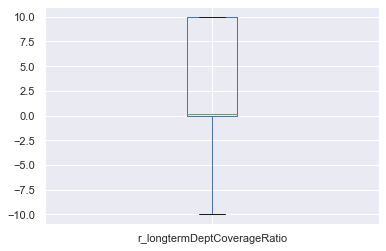

In [ ]:
df_sec[~(df_sec.r_longtermDeptCoverageRatio == np.inf)].r_longtermDeptCoverageRatio.plot.box()

In [ ]:
#df['r_longtermDeptCoverageRatio']  =  (df.CashFromOperating - df.PaymentsOfDividendsTotal_hj) / df.LiabilitiesNoncurrent

df_sec.loc[df_sec.r_longtermDeptCoverageRatio.isnull()][['ticker','r_longtermDeptCoverageRatio','CashFromOperating', 'PaymentsOfDividendsTotal_hj', 'LiabilitiesNoncurrent']]

,ticker,r_longtermDeptCoverageRatio,CashFromOperating,PaymentsOfDividendsTotal_hj,LiabilitiesNoncurrent
497,AB,NaN,11756000.0,11756000.0,0.0
12832,CFD,NaN,2673580.0,2673580.0,0.0
14865,CFD,NaN,6683950.0,6683950.0,0.0
18730,CFD,NaN,10417739.0,10417739.0,0.0
35583,CTF,NaN,4153193.0,4153193.0,0.0
37493,CFD,NaN,2107960.0,2107960.0,0.0
40336,CFD,NaN,4903495.0,4903495.0,0.0
40886,CTF,NaN,9988655.0,9988655.0,0.0
41831,CTF,NaN,15202987.0,15202987.0,0.0
42803,CFD,NaN,7174305.0,7174305.0,0.0


## XX_Trials

In [ ]:
print(len(add_info.sector.unique()))
print(len(add_info.industry.unique()))

12
29


In [ ]:
add_info.sector.value_counts()

FinancialServices        375
Industrials              324
Technology               293
Healthcare               264
ConsumerCyclical         235
RealEstate               131
Energy                   115
ConsumerDefensive        102
BasicMaterials            85
CommunicationServices     81
Utilities                 54
IndustrialGoods            1
Name: sector, dtype: int64

In [ ]:
industries = add_info.industry.value_counts()
industries[industries > 20].index.tolist()

['Other',
 'BanksRegional',
 'Biotechnology',
 'SoftwareApplication',
 'SpecialtyIndustrialMachinery',
 'OilGasEP',
 'Semiconductors',
 'MedicalDevices',
 'InformationTechnologyServices',
 'PackagedFoods',
 'InsurancePropertyCasualty',
 'SpecialtyChemicals',
 'SoftwareInfrastructure',
 'MedicalInstrumentsSupplies',
 'AutoParts',
 'CommunicationEquipment',
 'SpecialtyRetail',
 'AssetManagement',
 'DiagnosticsResearch',
 'ElectronicComponents',
 'AerospaceDefense',
 'Restaurants',
 'OilGasEquipmentServices',
 'ScientificTechnicalInstruments',
 'CreditServices',
 'OilGasMidstream',
 'SpecialtyBusinessServices',
 'ApparelRetail',
 'SemiconductorEquipmentMaterials']

In [ ]:
add_info[add_info.marketCap_rank < 15].sort_values('marketCap_rank')

,ticker,sector,industry,marketCap,sharesOutstanding,message,sec__BasicMaterials,sec__CommunicationServices,sec__ConsumerCyclical,sec__ConsumerDefensive,...,ind__SpecialtyRetail,marketCap_rank,mc_top10,mc_top20,mc_top30,mc_top50,mc_top100,mc_top200,mc_top500,mc_top1000
2,AAPL,Technology,Other,2.081190e+12,1.710250e+10,NaN,0,0,0,0,...,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1951,MSFT,Technology,SoftwareInfrastructure,1.612352e+12,7.560500e+09,NaN,0,0,0,0,...,0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
914,AMZN,ConsumerCyclical,Other,1.563667e+12,5.008900e+08,NaN,0,0,1,0,...,0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
203,FB,CommunicationServices,Other,7.791497e+11,2.403970e+09,NaN,0,1,0,0,...,0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
834,TSLA,ConsumerCyclical,Other,5.782101e+11,9.479010e+08,NaN,0,0,1,0,...,0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
61,V,FinancialServices,CreditServices,4.546376e+11,1.695680e+09,NaN,0,0,0,0,...,0,6.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1699,WMT,ConsumerDefensive,Other,4.159056e+11,2.829290e+09,NaN,0,0,0,1,...,0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1480,JNJ,Healthcare,Other,4.026470e+11,2.632540e+09,NaN,0,0,0,0,...,0,8.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
740,JPM,FinancialServices,Other,3.644428e+11,3.048200e+09,NaN,0,0,0,0,...,0,9.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1132,PG,ConsumerDefensive,Other,3.384916e+11,2.479610e+09,NaN,0,0,0,1,...,0,10.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
add_info.industry.unique()

array(['Airlines', 'Semiconductors', 'Consumer Electronics',
       'Insurance—Life', 'Specialty Retail',
       'Building Products & Equipment', 'Aluminum', 'REIT—Diversified',
       'Diagnostics & Research', 'Banks—Regional',
       'Specialty Business Services', 'Auto & Truck Dealerships',
       'Asset Management', 'Medical Devices', 'REIT—Mortgage',
       'Medical Distribution', 'Scientific & Technical Instruments',
       'Drug Manufacturers—General', 'Biotechnology', 'REIT—Residential',
       'Information Technology Services', 'Electronic Components',
       'Specialty Industrial Machinery', 'Oil & Gas Equipment & Services',
       'Travel Services', 'Electrical Equipment & Parts',
       'Other Industrial Metals & Mining', 'Packaged Foods',
       'Security & Protection Services', 'Apparel Manufacturing',
       'Credit Services', 'Oil & Gas E&P', 'Oil & Gas Midstream',
       'Medical Instruments & Supplies', 'Insurance—Property & Casualty',
       'Software—Infrastructure'

herausfinden, welche ticker zu welcher cik gehoeren, falls mehrere cicks pro ticker vorhanden sind

mit additional daten mixen und features erzeugen

shares_outstanding mixen -> evtl. earnings pershare basierend auf aktueller Anzahl Aktien?


prüfen der Daten, ob alles komplett vorhanden ist


In [ ]:
adf = read_additional_info()
adf[adf.message.isna()]

,ticker,sector,industry,marketCap,sharesOutstanding,message
0,AAL,Industrials,Airlines,1.041370e+10,6.107740e+08,NaN
1,AAOI,Technology,Semiconductors,1.782953e+08,2.297620e+07,NaN
2,AAPL,Technology,Consumer Electronics,2.081190e+12,1.710250e+10,NaN
3,AAME,Financial Services,Insurance—Life,4.634046e+07,2.041430e+07,NaN
4,AAN,Consumer Cyclical,Specialty Retail,5.985550e+08,3.377850e+07,NaN
...,...,...,...,...,...,...
3037,FDP,Consumer Defensive,Farm Products,1.228697e+09,4.736690e+07,NaN
3039,SCOR,Communication Services,Advertising Agencies,1.805105e+08,7.278650e+07,NaN
3042,MDRX,Healthcare,Health Information Services,2.265462e+09,1.579820e+08,NaN
3044,GILD,Healthcare,Drug Manufacturers—General,7.616448e+10,1.253530e+09,NaN
